In [8]:
"""""""""""""
#created on Mon Nov 17

""""""""""""
#author:Simon H


import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np

data_root = "/kaggle/input/covid-data/COVID-9 数据集和h5/COVID-19_Radiography_Dataset"

covid_dir = os.path.join(data_root, "COVID-19")
normal_dir = os.path.join(data_root, "NORMAL")
pneumonia_dir = os.path.join(data_root, "Viral Pneumonia")

print("COVID path:", covid_dir)
print("NORMAL path:", normal_dir)
print("Pneumonia path:", pneumonia_dir)

COVID path: /kaggle/input/covid-data/COVID-9 数据集和h5/COVID-19_Radiography_Dataset/COVID-19
NORMAL path: /kaggle/input/covid-data/COVID-9 数据集和h5/COVID-19_Radiography_Dataset/NORMAL
Pneumonia path: /kaggle/input/covid-data/COVID-9 数据集和h5/COVID-19_Radiography_Dataset/Viral Pneumonia


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder(root=data_root, transform=transform)

# 划分训练/验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=2)

print("Train size:", len(train_set))
print("Val size:", len(val_set))
print("Classes:", dataset.classes)

Train size: 12122
Val size: 3031
Classes: ['COVID-19', 'NORMAL', 'Viral Pneumonia']


In [10]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [11]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3,
                 red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1),
        )

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim=1)

In [12]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.pool = nn.AvgPool2d(5, 3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, 0.7, train=self.training)
        x = self.fc2(x)
        return x

In [13]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=3, aux_logits=True):
        super(GoogLeNet, self).__init__()

        self.aux_logits = aux_logits

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, padding=1)

        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.maxpool4 = nn.MaxPool2d(3, 2, padding=1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.maxpool1(self.conv1(x))
        x = self.maxpool2(self.conv2(x))

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        aux1 = None
        aux2 = None

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.aux_logits and self.training:
            return aux1, aux2, x
        else:
            return x


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GoogLeNet(num_classes=3, aux_logits=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5

train_acc_list = []
val_acc_list = []
val_precision_list = []
val_recall_list = []
val_f1_list = []
val_conf_mat = None

In [15]:

for epoch in range(num_epochs):
    model.train()
    total, correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        aux1, aux2, outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux1, labels)
        loss3 = criterion(aux2, labels)
        loss = loss1 + 0.3 * (loss2 + loss3)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    train_acc = correct / total
    train_acc_list.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.3f}")

    model.eval()
    val_total, val_correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.max(1)

            val_total += labels.size(0)
            val_correct += pred.eq(labels).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    val_acc_list.append(val_acc)

    val_precision = precision_score(all_labels, all_preds, average="macro")
    val_recall = recall_score(all_labels, all_preds, average="macro")
    val_f1 = f1_score(all_labels, all_preds, average="macro")

    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)
    val_f1_list.append(val_f1)


    val_conf_mat = confusion_matrix(all_labels, all_preds)

    print(f"  Val Acc: {val_acc:.3f} | Precision: {val_precision:.3f} | Recall: {val_recall:.3f} | F1: {val_f1:.3f}")

torch.save(model.state_dict(), "googlenet_covid3.pth")
print("训练完成，模型已保存。")


Epoch 1/5, Train Acc: 0.894
  Val Acc: 0.938 | Precision: 0.926 | Recall: 0.894 | F1: 0.908
Epoch 2/5, Train Acc: 0.952
  Val Acc: 0.962 | Precision: 0.936 | Recall: 0.948 | F1: 0.941
Epoch 3/5, Train Acc: 0.967
  Val Acc: 0.974 | Precision: 0.968 | Recall: 0.959 | F1: 0.963
Epoch 4/5, Train Acc: 0.975
  Val Acc: 0.954 | Precision: 0.939 | Recall: 0.964 | F1: 0.950
Epoch 5/5, Train Acc: 0.974
  Val Acc: 0.970 | Precision: 0.962 | Recall: 0.959 | F1: 0.960
训练完成，模型已保存。


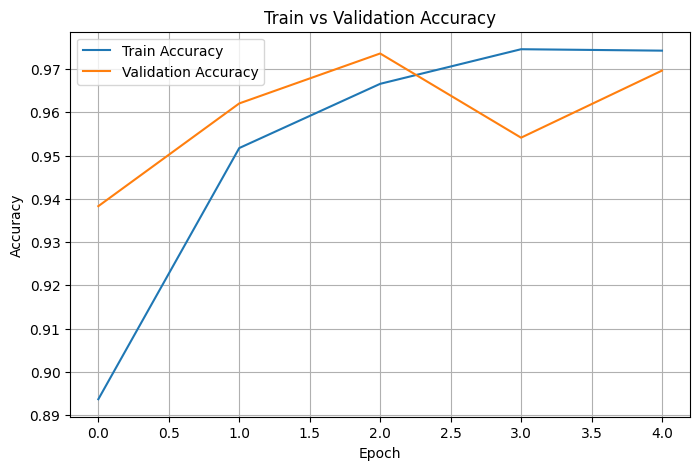

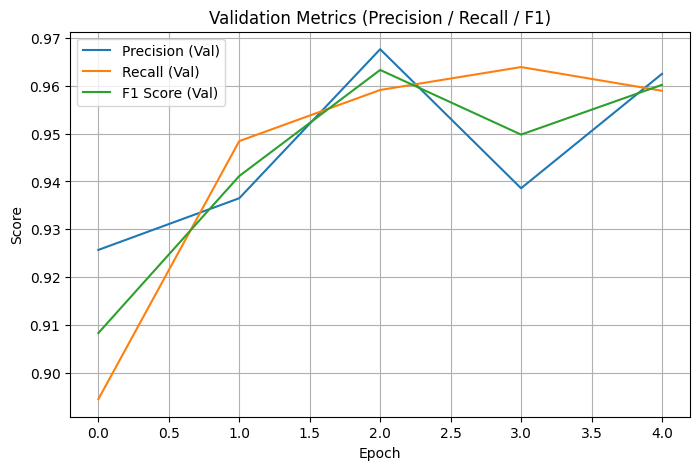

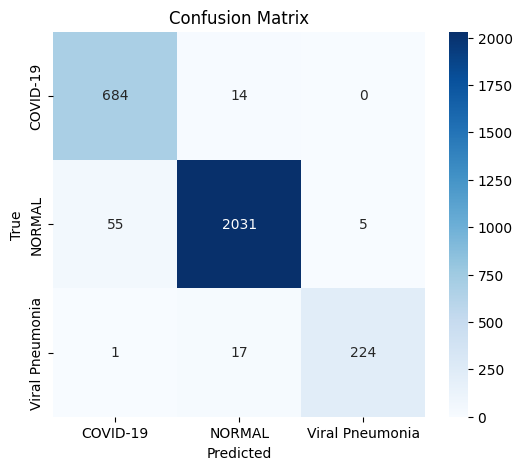

In [16]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(val_precision_list, label="Precision (Val)")
plt.plot(val_recall_list, label="Recall (Val)")
plt.plot(val_f1_list, label="F1 Score (Val)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics (Precision / Recall / F1)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(val_conf_mat, annot=True, fmt="d",
            cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Macro-average AUC : 0.9957
Micro-average AUC : 0.9971


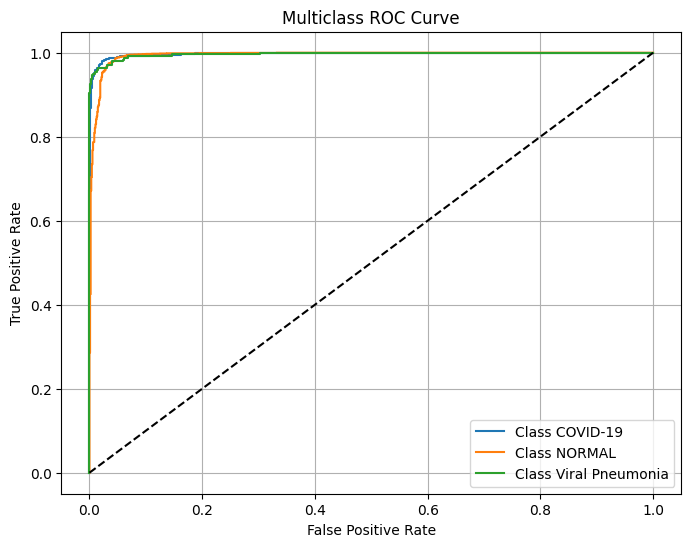

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)  # 转概率
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# 独热编码
y_true_bin = label_binarize(all_labels, classes=[0,1,2])  
n_classes = y_true_bin.shape[1]


auc_macro = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
auc_micro = roc_auc_score(y_true_bin, all_probs, average="micro", multi_class="ovr")

print(f"Macro-average AUC : {auc_macro:.4f}")
print(f"Micro-average AUC : {auc_micro:.4f}")

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {dataset.classes[i]}")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
